# 🔰PyTorchでニューラルネットワーク基礎 #09 【LSTM・多次元化】
## 4次元データ入力LSTMを利用した株価の予測

## 内容
* Qiitaの記事と連動しています
* LSTMの使い方
* 時系列データである株価を利用してLSTMの構造を学習する

## データについて
* データ：data/nikkei_225.csv
* 2021年から2025年6月中旬くらいのデータ
* 日経225データはyfinanceを利用して取得

## ちょっとした注意点
* CPUでもできるけどGPU（ゲーム用ノートPC搭載のGPUでもOK）あると高速に学習できる
* Google ColaboratoryでももちろんOK

## その他
* 最後の100期間をテストデータ、それ以前はすべて学習データとする。
* 入力データをscaling_factor = 10_000で割り算する。日経平均が万の単位であるので10_000で割り数値を3前後の小さな値にすることで学習を安定化させることができる。
* 始値だけの予測よりも、4種類利用するほうがナイーブ予測より良い結果になりやすい
* 入力データの特徴量の種類を増やすことで、ナイーブな予測（1期ズレ）よりもrealに近い値になる。


In [1]:
import pandas as pd
import numpy as np

In [2]:
# CSVファイルの読み込み
filename = "./data/nikkei_225.csv"
data = pd.read_csv(filename)
data.head(5)

,Date,Open,High,Low,Close,Volume
0,2021-01-04,27575.57,27602.11,27042.32,27258.38,51500000
1,2021-01-05,27151.38,27279.78,27073.46,27158.63,55000000
2,2021-01-06,27102.85,27196.40,27002.18,27055.94,72700000
3,2021-01-07,27340.46,27624.73,27340.46,27490.13,98900000
4,2021-01-08,27720.14,28139.03,27667.75,28139.03,84900000


In [3]:
# 日経225の値を10,000円で割り算して値を小さくする
#
scaling_factor = 10_000
x_open = data["Open"]/scaling_factor
x_high = data["High"]/scaling_factor
x_low = data["Low"]/scaling_factor
x_close = data["Close"]/scaling_factor

In [4]:
win_size = 5

XO = [x_open[start:start+win_size] for start in range(len(data)-win_size)]
XH = [x_high[start:start+win_size] for start in range(len(data)-win_size)]
XL = [x_low[start:start+win_size] for start in range(len(data)-win_size)]
XC = [x_close[start:start+win_size] for start in range(len(data)-win_size)]

T = x_open[win_size:]

xo = np.array(XO)
xh = np.array(XH)
xl = np.array(XL)
xc = np.array(XC)
t  = np.array(T)
xo = xo.reshape(-1, win_size, 1)
xh = xh.reshape(-1, win_size, 1)
xl = xo.reshape(-1, win_size, 1)
xc = xh.reshape(-1, win_size, 1)

x = np.concatenate([xo, xh, xl, xc], axis=2)
x.shape, t.shape

((1087, 5, 4), (1087,))

## 3. LSTMを利用したネットワークの作成と学習

In [5]:
import torch
import torch.nn as nn

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

x = torch.FloatTensor(x).to(device)
t = torch.FloatTensor(t).to(device).view(-1,1)


period = 100
x_train = x[:-period]
x_test = x[-period:]
t_train = t[:-period]
t_test = t[-period:]

x_train.shape, x_test.shape, t_train.shape, t_test.shape

device: cuda


(torch.Size([987, 5, 4]),
 torch.Size([100, 5, 4]),
 torch.Size([987, 1]),
 torch.Size([100, 1]))

### ネットワークの構造
4 dim --> LSTM --> FC1 --> FC2 --> 1 dim

In [7]:
## モデル定義
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn  = nn.LSTM(input_size=4 ,hidden_size=100, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(100, 50)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        o, (h, c)  = self.rnn(x)
        #o = o[:,-1,:]=h[-1] : 最後のステップの出力
        last_output = h[-1]
        h = self.fc1(last_output)
        h = self.act1(h)
        y = self.fc2(h)
        return y

In [8]:
# ハイパーパラメータ
LOOP = 8_000 # 1000

In [9]:
model = DNN()
model.to(device)

DNN(
  (rnn): LSTM(4, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
# 損失関数と最適化関数の定義
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())

In [11]:
# 学習ループ
model.train()
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x_train)
    loss = criterion(y,t_train)
    if (epoch+1)%1000 == 0:
        print(epoch,"\tloss:", loss.item())
    loss.backward()
    optimizer.step()

999 	loss: 0.0020220272708684206
1999 	loss: 0.0013492990983650088
2999 	loss: 0.0010874009458348155
3999 	loss: 0.001107796560972929
4999 	loss: 0.0010358970612287521
5999 	loss: 0.0009440910653211176
6999 	loss: 0.000950332498177886
7999 	loss: 0.0009224597597494721


# グラフ

In [12]:
import matplotlib.pyplot as plt
import japanize_matplotlib

In [13]:
model.eval()
y_test = model(x_test)

prediction = y_test.detach().cpu().numpy()
real = t_test.detach().cpu().numpy()
y_train = t_train.detach().cpu().numpy()

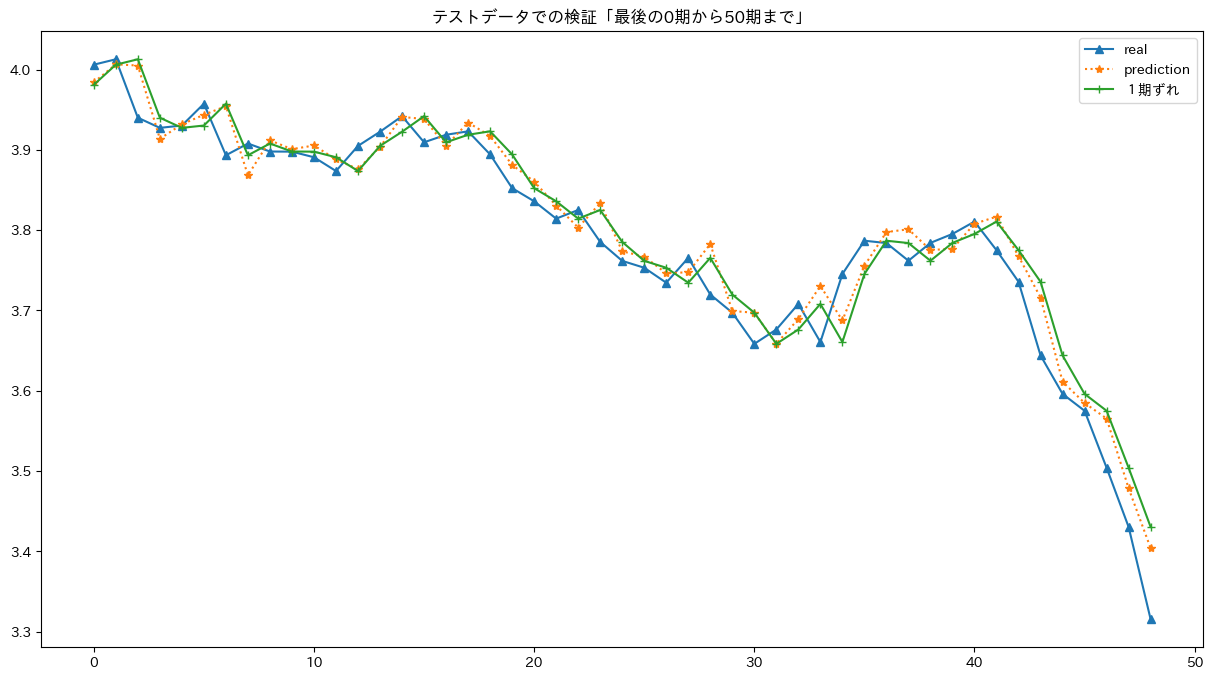

In [16]:
s = 0 # s=0
e = s+50 # s+表示期間

plt.figure(figsize=(15,8))
plt.plot(real[s+1:e], label="real",marker="^")
plt.plot(prediction[s+1:e], label="prediction", linestyle="dotted", marker="*")
plt.plot(real[s:e-1], label="１期ずれ", marker="+")
plt.legend()
name = f"テストデータでの検証「最後の{s}期から{e}期まで」"
plt.title(name)
plt.show()